#### Hongqiang Zhou

Silver Spring, MD

This has been the capstone project for the Certificate in Data Science program I have attended at University of Washington, Seattle, between October 2016 and June 2017. Many thanks to my wonderful instructors: Dr. Ernst Henle (https://www.linkedin.com/in/ernsthenle/), Dr. Stephen Elston (https://www.linkedin.com/in/selston/), and Dr. Wee Hyong Tok (https://www.linkedin.com/in/weehyongtok/), and my inspiring teammates: Hui and Chunming. The original solutions were obtained with R. I rewrite the scripts in Python to take advantage of its machine learning package of 'scikit-learn'. 

So far, I have practiced the following approaches: logistic regression, decision tree, random forest, and AdaBoost classifier. If time allows, I will continue this research and have more validated approaches added into this list.

In this study, we populate the training data through SMOTE (Synthetic Minority Over-sampling TEchnique). This algorithm creates synthetic data points of minority class so as to balance the classes. Here, I emphasize that oversampling cannot be applied to validation (if there is)  and test data, and cross-validation within training data must also be disabled.

We first load the Python functions to be employed in this project.

In [1]:
from __future__ import division # In case of Python 2.7.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import probplot
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from itertools import cycle
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

plt.rcParams.update({'font.size': 12})
%matplotlib inline

### The data

We build our models on a dataset obtained at "https://www.kaggle.com/dalpozz/creditcardfraud/data", which includes credit transactions made in Europe during a 48-hour period in September 2013. In below cell, we load the data and take a quick peek.

In [2]:
#data = pd.read_csv('../input/creditcard.csv')
data = pd.read_csv('creditcard.csv')
data.head(n = 5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Make sure that the data is 'hygienic'.

In [3]:
np.isnan(data).any().values.reshape(1, -1)

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False]], dtype=bool)

The feature 'Class' is the classification label. As described at Kaggle, the records are very unbalanced.

In [4]:
print ('No. of genuine transactions: {0:g}\nNo. of fraudulent transactions: {1:g}'.format( \
        np.sum(data['Class'] == 0), np.sum(data['Class'] == 1)))

No. of genuine transactions: 284315
No. of fraudulent transactions: 492


The first column is time. We believe it is only an indicator and does not affect the classification. The remaining columns are divided into 'features' and 'label'. The former are employed as predictors, and the latter target.

In [5]:
features = data.columns
features = [str(s) for s in features]
label = features[-1]
features = features[1:-1] # Time is only an indicator instead of a useful feature.

data = data[features + [label]]

In below cell, we plot the real distribution of data against standard normal distribution. Note that some features do not look to obey normal distribution. Some machine learning theories are built upon the assumption of normal distribution. This may cause poor performance of this methods on the present data set.

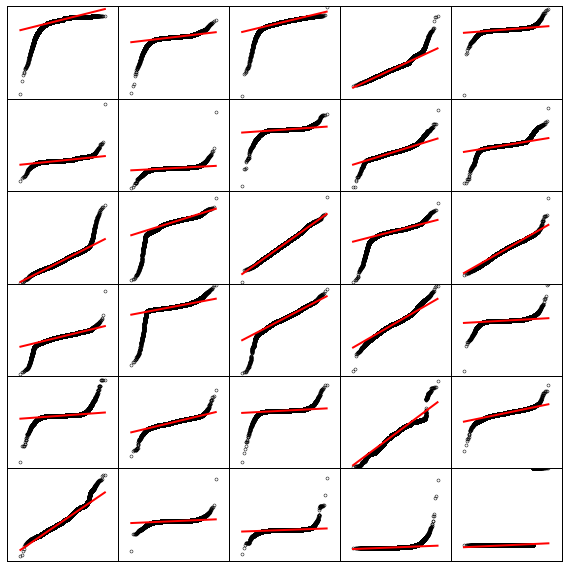

In [6]:
plt.figure(figsize = (8, 8))
k = 0
for i in range(6):
    for j in range(5):
        ax = plt.subplot(6, 5, k+1)
        probplot(data.iloc[:, k], dist = 'norm', plot = plt)
        ax.get_lines()[0].set_markersize(3)
        ax.get_lines()[0].set_markerfacecolor('None')
        ax.get_lines()[0].set_markeredgecolor('k')
        ax.get_lines()[1].set_linewidth(2)
        ax.set_xticks([])
        ax.set_xlabel('')
        ax.set_yticks([])
        ax.set_ylabel('')
        ax.set_title('')
        k += 1

plt.tight_layout()
plt.subplots_adjust(wspace = 0, hspace = 0)    

We normalize the data through standard scalar, which removes the mean and scales the data to unit variance. The mean and standard deviation of each feature need to be retained. Application of the models trained in this study to new data requires that these data be normalized based on the same scaling parameters we obtain here.

In [7]:
scaler = StandardScaler().fit(data[features])
scaler_mean = scaler.mean_
scaler_scale = scaler.scale_
data[features] = scaler.transform(data[features])

We then partition the data into three datasets, i.e., train, validation, and test datasets.

In [8]:
train_data, val_test_data = train_test_split(data, test_size = 0.4, random_state = 1)
val_data, test_data = train_test_split(val_test_data, test_size = 0.5, random_state = 1)

As discussed before, the data is highly unbalanced. Before training classification models, we populate the minority class with synthetic data through SMOTE. Note that over-sampling is only applied to trainding data. Validation and test of learned models must be conducted on original data.

In [9]:
X = train_data[features]
y = train_data[label]

sm = SMOTE(ratio = 'auto', kind = 'regular', random_state = 1)
sample_X, sample_y = sm.fit_sample(X, y)
sample = pd.concat([pd.DataFrame(sample_X), pd.DataFrame(sample_y)], axis = 1)
sample.columns = features + [label]

In further study, 'sample' dataset will be our training data. A quick check shows that this data is perfectly balanced.

In [10]:
print ('No. of fraudulent transactions: {0:g}\nNo. of genuine transactions: {1:g}'.format( \
        np.sum(sample['Class'] == 0), np.sum(sample['Class'] == 1)))

No. of fraudulent transactions: 170578
No. of genuine transactions: 170578


#### Logistic regression

There are 29 predictors in the dataset, and some features may not be as important as others. We first remove some relatively insignificant features through LASSO regularization. 

What is the right measure of model performance seems to have an easy and straightforward answer: accuracy. In this study, accuracy may not be an ideal option. Since the data is very unbalanced, simply predicting every data point into majority class ('fraud') can yield almost perfect accuracy. For example for the test dataset, the proportion of majority class is as high as 99.8%.

In [11]:
sum(test_data[label] == 0) / float(len(test_data))

0.99827955479091324

In classification problems, people care more about recall, precision, and the trade-off between false positive rate (FPR) and true positive rate (TPR). In tuing the models in this study, we gauge model performances with area under ROC (Receiver and Operating Characteristic) curve (AUC).

In [12]:
def tune_clf(models, param_name, param_values, train_data, val_data, features, label):
    auc_scores = []
    param_cycle = cycle(param_values)
    for model in models:
        model.fit(train_data[features], train_data[label])
        probs = model.predict_proba(val_data[features])
        auc_scores.append(roc_auc_score(y_true = val_data[label], y_score = probs[:, 1]))
        """ If you don't mind seeing the output, un-comment the following line. """
        #print(param_name + ' = {0:g}, auc = {1:.4f}'.format(next(param_cycle), 
        #auc_scores[-1])) 
        
    fig, ax = plt.subplots(figsize = (6, 6))
    plt.plot(param_values, auc_scores, 'b-o', linewidth = 2)
    plt.xlabel(param_name)
    plt.ylabel('auc')
    plt.tight_layout()
    plt.show()
    
    return models, auc_scores 

In tuning the model with 'L1' norms, we first search within log-spaced values of large range.

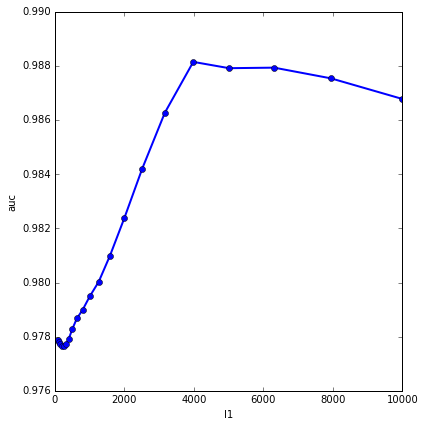

In [13]:
param_values = np.logspace(2, 4, 21)
models = []
for param_value in param_values:
    models.append(LogisticRegression(random_state = 1, penalty = 'l1', 
                                     C = 1.0/param_value))
    
models, auc_scores = tune_clf(models, 'l1', param_values, sample, val_data, 
                              features, label) 

We then zoom our search around the point identified with the highest AUC in the previous step.

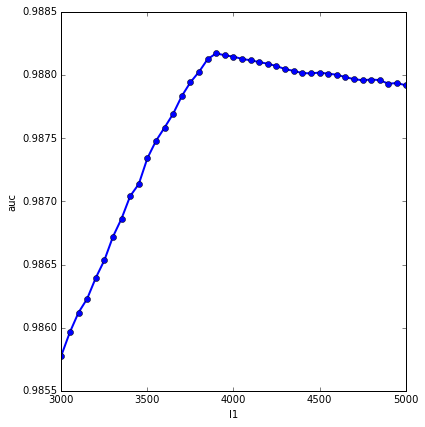

In [14]:
param_values = np.linspace(3000, 5000, 41)
models = []
for param_value in param_values:
    models.append(LogisticRegression(random_state = 0, penalty = 'l1', 
                                     C = 1.0/param_value))

models, auc_scores = tune_clf(models, 'l1', param_values, sample, val_data, 
                              features, label)

It seems the AUC does not vary too much in this search. In below cells, we find the optimum 'L1' norm, and evaluate the model on test data.

In [20]:
def model_evaluation(model, feature_matrix, target):
    probs = model.predict_proba(feature_matrix)[:, 1]
    (fpr, tpr, thresholds) = roc_curve(y_true = target, y_score = probs)
    auc_score = auc(x = fpr, y = tpr)
    fig, ax = plt.subplots(figsize = (6, 6))
    ax.plot(fpr, tpr, 'r-', linewidth = 2)
    ax.plot([0, 1], [0, 1], 'k--', linewidth = 1)
    plt.title('ROC curve with AUC = {0:.3f}'.format(auc_score))
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.axis([-0.01, 1.01, -0.01, 1.01])
    plt.tight_layout()
    
    return {'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds, 'auc': auc_score}  

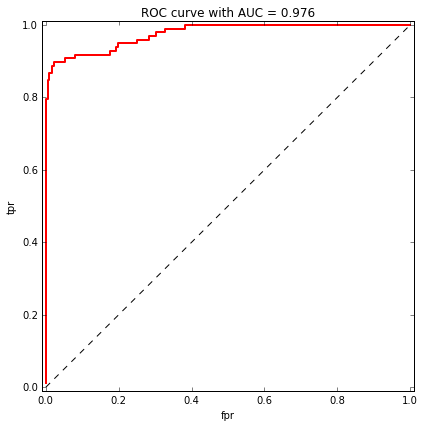

In [21]:
idx = np.where(auc_scores == np.max(auc_scores))[0][0]
best_l1 = param_values[idx]
lr_lasso = models[idx]
roc = model_evaluation(lr_lasso, test_data[features], test_data[label])

Obtained AUC is 0.976. To classify an instance with a regression model, the model first computes the probabilities of either class. If the probability of positive class is higher than a chosen threshold, this instance will be marked positive, and vice versa. In below figure, we show the FPR and TPR as a function of threshold.

In [22]:
def plot_roc(thresholds, fpr, tpr):
    plt.figure(figsize = (6, 6))
    plt.plot(roc['thresholds'], roc['tpr'], 'r-', linewidth = 2, label = 'tpr')
    plt.plot(roc['thresholds'], roc['fpr'], 'b-', linewidth = 2, label = 'fpr')
    plt.axis([-0.01, 1.01, -0.01, 1.01])
    plt.legend(loc = 'best')
    plt.xlabel('threshold')
    plt.ylabel('tpr, fpr')
    plt.tight_layout()

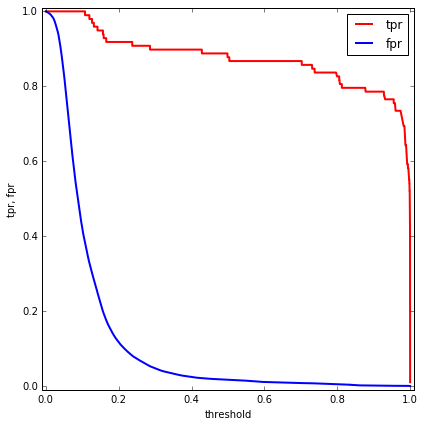

In [23]:
plot_roc(roc['thresholds'], roc['fpr'], roc['tpr'])

We note that at threshold between 0.2 and 0.8, FPR is generally very small while TPR is high. This range of threshold makes pretty decent model performance. For threshold lower than 0.1, TPR is nearly perfect but meanwhile FPR is also very high. It is not diffult to find the threshold that yields the highest TPR and lowest FPR, but this may not be the best option we want in real world. Besides technical issues, we also need to consider many other factors, such as the cost to verify suspicious transactions and possible loss of business. This is mainly an assignment for business managers not a machine learning geek. Here we practice with a threshold of 0.8. This criterion is very conservative. The model will limit the instances of misslabeling genuine transactions as fraud at the cost of missing a lot of real frauds.

In [28]:
def model_prediction(model, threshold, feature_matrix, target):
    probs = model.predict_proba(feature_matrix)[:, 1]
    preds = np.where(probs > threshold, 1, 0)
    tn, fp, fn, tp = confusion_matrix(y_true = target, y_pred = preds).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / float(len(target))    
    return {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp, 'precision': precision, 
                   'recall': recall, 'accuracy': accuracy}

In [29]:
metrics = model_prediction(lr_lasso, 0.8, test_data[features], test_data[label])
metrics

{'accuracy': 0.99462799761244336,
 'fn': 17,
 'fp': 289,
 'precision': 0.21891891891891893,
 'recall': 0.82653061224489799,
 'tn': 56575,
 'tp': 81}

We see the model correctly identifies 81 out of 98 frauds; mislabels 289 genuine transactions; and meanwhile misses 17 real frauds. I remember sometimes I was called and asked to verify a recent transaction. Obviously the classification model my credit card issuer has mislabeled this transation as 'fraudulent'.

It is also of interest to see what features are considered important in this model. In below cell, we see 12 out of 29 features are considered significant.

In [33]:
selected_features = list(np.array(features)[lr_lasso.coef_[0, :] != 0])
print selected_features

['V4', 'V6', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V16', 'V21', 'V23']


We then create a new regression model with selected features only, and tune the model with 'L2' norms. This is called ridge regularization.

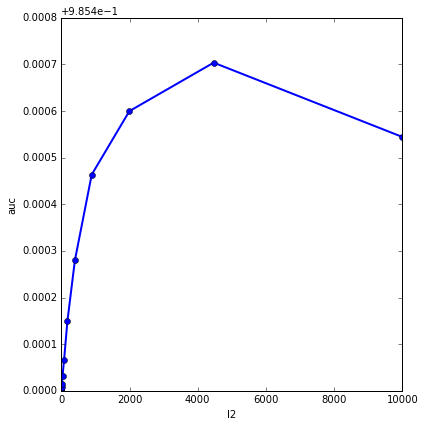

In [36]:
param_values = np.logspace(-3, 4, 21)
models = []
for param_value in param_values:
    models.append(LogisticRegression(random_state = 1, penalty = 'l2', 
                                     C = 1.0/param_value))

models, auc_scores = tune_clf(models, 'l2', param_values, sample, val_data, 
                              selected_features, label) 

It shows model performance is not very sensative to 'L2' penalty. Probably we can run the model without tuning the 'L2' penalty. In that case, employ a very high value of 'C' (say, C = 1e6) in the function.

Physical oceanographers, like me, often deal with tidal harmonics. A common approach to derive harmonic components from a time series of tidal elevations is to first choose major harmonics through LASSO regression, and then compute parameters of chosen harmonics through least-squares method. The same procedure may be applied to this one.

### Decision tree classifier

Performance of a decision tree classifier are governed by many parameters in the model. Unfortunately, the 'scikit-learn' package does not have a tree pruning function like that in R. Here we only tune the maximum depth of the tree model.

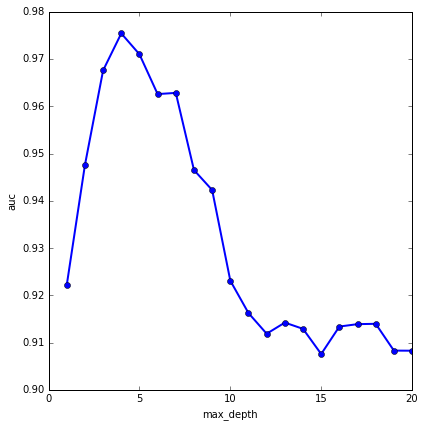

In [37]:
param_values = np.arange(1, 21, 1)
models = []
for param_value in param_values:
    models.append(DecisionTreeClassifier(random_state = 1, criterion = 'entropy', 
                                         max_depth = param_value))

models, auc_scores = tune_clf(models, 'max_depth', param_values, sample, val_data, 
                              features, label)

We then identify the best value of maximum depth and evaluate this model on test data.

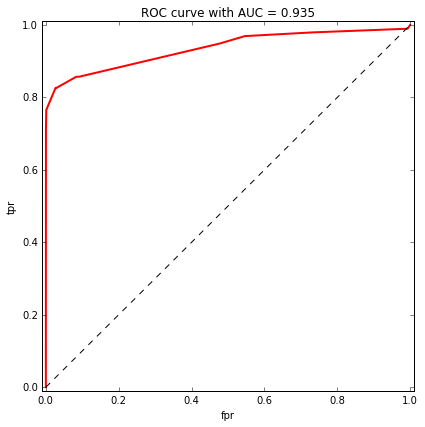

In [38]:
idx = np.where(auc_scores == np.max(auc_scores))[0][0]
best_depth = param_values[idx]
best_tree = models[idx]
roc = model_evaluation(best_tree, test_data[features], test_data[label])

Performance of this decision tree is not impressive. We believe there still is great potential for improvement. Unfortunately, tuning a particular parameter requires a lot of try-and-error, and it is not easy to do on a regular PC. 

### Random forest
After frusted by the decision tree classification, here comes Random Forest as a rescue. Random forest is an ensemble of decision trees. The algorithm builds a number of trees on various sub-samples of the dataset and uses averaging to improve accuracy and control over-fitting. We first build a random forest model with 200 trees of maximum depth equal to 5.

In [39]:
rf = RandomForestClassifier(random_state = 1, n_estimators = 200, max_depth = 5, 
                            bootstrap = True, criterion = 'entropy')
rf.fit(sample[features], sample[label])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

We then tune the number of trees in this model.

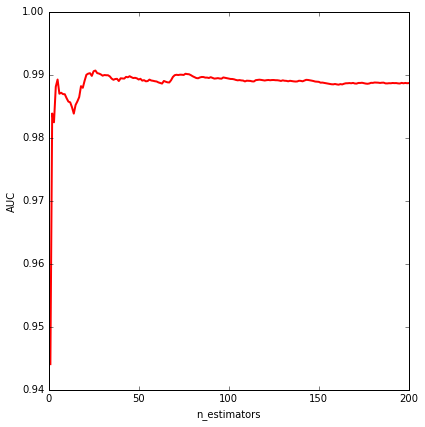

In [40]:
tree_clumps = rf.estimators_
auc_scores = []
avg_probs = np.zeros(val_data.shape[0])
for i in range(len(tree_clumps)):
    probs = tree_clumps[i].predict_proba(val_data[features])[:, 1]
    avg_probs += probs
    auc_scores.append(roc_auc_score(val_data[label], avg_probs / float(i+1)))
    #print('No. of stumps = {0:g}, auc = {1:.5f}'.format(i, auc_scores[-1]))    
    
fig, ax = plt.subplots(figsize = (6, 6))
ax.plot(np.arange(1, 201), auc_scores, 'r-', linewidth = 2)
plt.xlabel('n_estimators')
plt.ylabel('AUC')
plt.tight_layout()

Ensemble methods, like random forest, are generally robust to over-fitting due to number of components. In above figure, we note model performance varies very little after number of trees exceeds 50. We evaluate the model on test data.

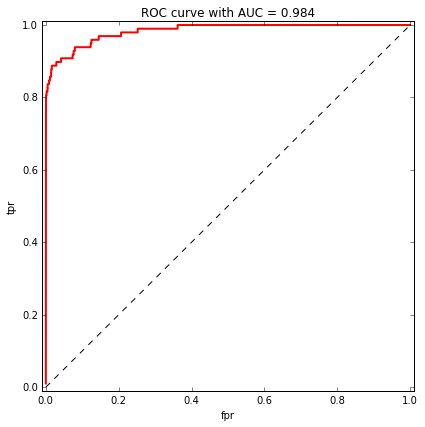

In [41]:
roc = model_evaluation(rf, test_data[features], test_data[label])

The AUC is 0.984, much better than that obtained in logistic regression. We then check FPR and TPR for various thresholds.

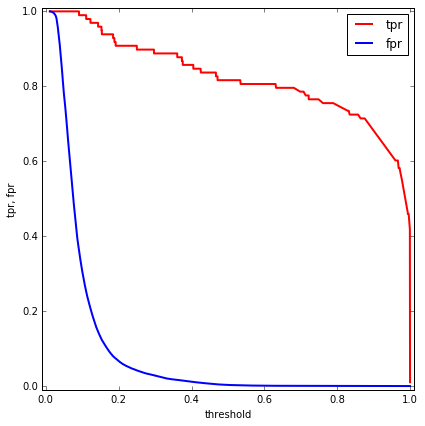

In [43]:
plot_roc(roc['thresholds'], roc['fpr'], roc['tpr'])

We note after threshold exceeds 0.5, FPR nearly becomes constant while TPR keeps declining. Here we choose the threshold of 0.5, and compute the metrics of model performance on test data.

In [48]:
metrics = model_prediction(rf, 0.5, test_data[features], test_data[label])
metrics

{'accuracy': 0.99676977634212283,
 'fn': 18,
 'fp': 166,
 'precision': 0.32520325203252032,
 'recall': 0.81632653061224492,
 'tn': 56698,
 'tp': 80}

This time, the model correctly identifies 80 out of 98 frauds; misses 18 real frauds; and mislabels 166 genuine transactions as fraudulent.
 
Like a single decision tree, we can also tune the properties of a random forest model, such as maximum depth, maximum leaf nodes, etc. By comparison with decision trees, tuning a random forest requires a lot more computer resources, and I would like to just stop here.

### AdaBoost classifier
Like random forest, AdaBoost classifier is an ensemble of decision trees. In building an AdaBoost classifier, the algorithm subsequently identifies misclassified data points and enlarges their weights. The prediction is made upon a sum of weighted predictions from component trees.

In [49]:
adb = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 1, \
                        max_depth = 1,criterion = 'entropy'), algorithm = 'SAMME', \
                        n_estimators = 100)
adb.fit(np.array(sample[features]), np.array(sample[label]))

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best'),
          learning_rate=1.0, n_estimators=100, random_state=None)

We then investigate the effect of component numbers on model performance.

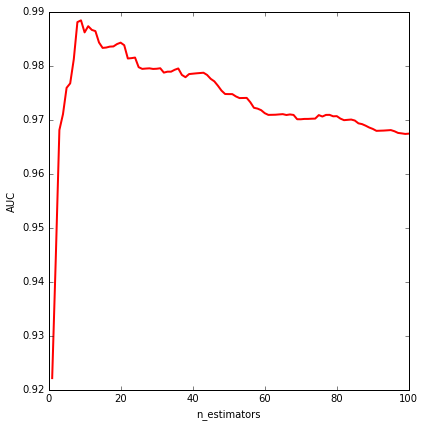

In [50]:
weights = adb.estimator_weights_
tree_clumps = adb.estimators_
weighted_probs = 0.0
auc_scores = []
for i in range(len(weights)):
    probs = tree_clumps[i].predict_proba(val_data[features])[:, 1]
    weighted_probs += weights[i] * probs
    auc_scores.append(roc_auc_score(val_data[label], 
                                    weighted_probs / sum(weights[0:i+1])))
    #print('No. of stumps = {0:g}, auc = {1:.5f}'.format(i, auc_values[-1]))

fig, ax = plt.subplots(figsize = (6, 6))
ax.plot(np.arange(1, len(weights)+1), auc_scores, 'r-', linewidth = 2)
plt.xlabel('n_estimators')
plt.ylabel('AUC')
plt.tight_layout()

Here we note a trend of over-fitting. We then identify the best number and evaluate the model on test data. The threshold is arbitrarily set to 0.5.

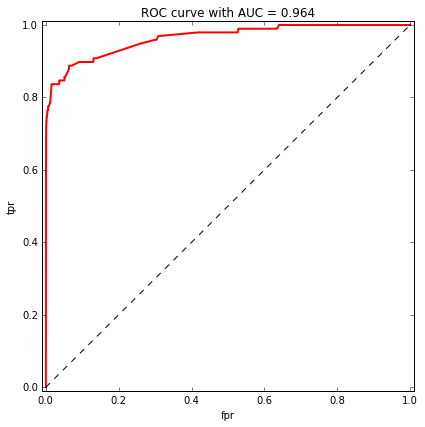

{'accuracy': 0.98793932797303463,
 'fn': 21,
 'fp': 666,
 'precision': 0.10363391655450875,
 'recall': 0.7857142857142857,
 'tn': 56198,
 'tp': 77}

In [51]:
idx = np.where(auc_scores == np.max(auc_scores))[0][0]
weighted_probs = np.zeros(len(test_data))

for i in range(idx+1):
    probs = tree_clumps[i].predict_proba(test_data[features])[:, 1]
    weighted_probs += weights[i] * probs
weighted_probs = weighted_probs/sum(weights[:idx+1])

preds = np.where(weighted_probs > 0.5, 1, 0)
tn, fp, fn, tp = confusion_matrix(y_true = test_data[label], y_pred = preds).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / float(test_data.shape[0])

(fpr, tpr, thresholds) = roc_curve(y_true = test_data[label], y_score = weighted_probs)
auc_value = auc(x = fpr, y = tpr)
fig, ax = plt.subplots(figsize = (6, 6))
ax.plot(fpr, tpr, 'r-', linewidth = 2)
ax.plot([0, 1], [0, 1], 'k--', linewidth = 1)
plt.title('ROC curve with AUC = {0:.3f}'.format(auc_value))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.axis([-0.01, 1.01, -0.01, 1.01])
plt.tight_layout()
plt.show()

metrics = {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp, 'precision': precision, 
                   'recall': recall, 'accuracy': accuracy}    
metrics

This model is slightly weaker than the fine-tuned logistic regression model, but significantly better than the decision tree model.

An AdaBoost classifier contains a number of one-level-deep decision trees ('estimators'). Each estimator also has a 'weight', which indicates the relative importance of this estimator in the whole ensemble. In below figure, we show the weights of the 100 estimators we have just constructed. It shows the first few estimators are the most important.

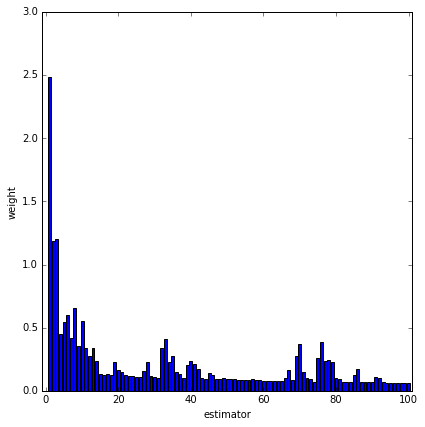

In [57]:
estimator = list(np.arange(1, 101))
plt.figure(figsize = (6, 6))
#plt.plot(estimator, adb.estimator_weights_, 'b-', linewidth = 2)
plt.bar(estimator, adb.estimator_weights_, align = 'center')
plt.axis([-1, 101, 0, 3])
plt.xlabel('estimator')
plt.ylabel('weight')
plt.tight_layout()

### Brief conclusion
In this study, we practice a few classification approaches in the open-source package of 'scikit-learn', i.e., logistic regression, decision tree classifier, random forest, and AdaBoost classifier. Though a linear method, the carefully fine-tuned logistic regression model is observed to yield reasonably good performance. Models based on decision tree classifiers ensembled through random forest and AdaBoost algorithms are easy to tune, and can obtain very good performance, thus are preferrable approaches. 

There are other machine learning approaches, such as support vector machine and multi-layer perceptron, I plan to practice in the near future. This notebook will be updated soon and often (hopefully).

##### Copyright reserved to Hongqiang Zhou (hongqiang.zhou@hotmail.com)
##### Last updated on Oct. 5, 2017

